In [1]:
import pandas as pd
import numpy as np
import matplotlib.backends.backend_tkagg
import matplotlib.pylab as plt
from astropy.io import fits
from astropy import units as units
import astropy.io.fits as pyfits
from astropy.convolution import Gaussian1DKernel, convolve
from extinction import calzetti00, apply, ccm89
from scipy import optimize
import sys
import time
import emcee
import corner
from multiprocessing import Pool,cpu_count
%matplotlib inline

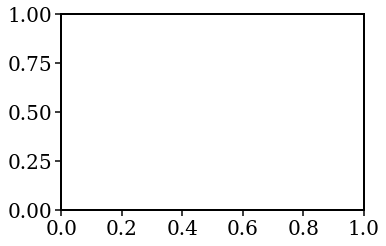

In [2]:
# from src.lib import *
pd.options.mode.chained_assignment = None 
np.warnings.filterwarnings('ignore')

current_dir = '/Volumes/My Passport/TPAGB/'
outcome_dir = 'outcome/'
plot_dir = 'plot/'
numeric_dir = 'numeric/'

plt.tight_layout()
plt.rc('lines', linewidth=3, markersize=2)
plt.rc('font', size=24, family='serif', weight=300)
plt.rc('mathtext', fontset='stix')
plt.rc('axes', linewidth=2)
plt.rc('xtick.major', width=1.5, size=6)
plt.rc('ytick.major', width=1.5, size=6)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.subplots_adjust(bottom=0.2, left=0.2)


In [3]:
def find_nearest(array, value):
    idx = np.argmin(np.abs(array-value))
    return idx

def best_model(df_opt,df_photometry,df_cat,df_fast,field):
    """
    input the dataframe
    Return the model with the best-fit values
    """
    #df_opt = df
    df_opt['field'] = field
    for i in range(len(df_opt)):
        ID = int(df_opt.iloc[i].ID)
        #print('ID',ID)
        #print(df_photometry.iloc[ID-1].f_F160W)
        #print(df_photometry.iloc[ID-1].e_F160W)
        if df_opt.iloc[i].model == 1 and df_opt.iloc[i].x2_spectra_M05_opt > 0.5 and df_opt.iloc[i].x2_M05 <60:
#             df_opt.loc[i,'age_opt'] = df_opt.iloc[i].M05_age_opt
#             df_opt.loc[i,'age_opt_std'] = df_opt.iloc[i].M05_age_std
#             df_opt.loc[i,'AV_opt'] = df_opt.iloc[i].M05_AV_opt
#             df_opt.loc[i,'AV_opt_std'] = df_opt.iloc[i].M05_AV_std
            m_AB_K = -2.5*np.log10(df_cat.iloc[ID-1].L163)+25.0
            M_AB_K = m_AB_K - df_cat.iloc[ID-1].DM-df_opt.iloc[i].AV_opt
            df_opt.loc[i,'M_K'] = M_AB_K
            galaxy_age = df_opt.iloc[i].M05_age_opt
            ML_K_index = find_nearest(BC_ML.log_age_yr.unique(), np.log10(galaxy_age*1e9))
            Intensity_ratio = 10**(-0.4*(M_AB_K-5.08))
            ML_K = BC_ML.iloc[ML_K_index].M_tot_Lk
            BC_mass = Intensity_ratio*ML_K
            df_opt.loc[i,'BC_ML'] = ML_K
            df_opt.loc[i,'BC_mass'] = BC_mass
            ML_K_index = find_nearest(M05_ML_002_JC.t.unique(), galaxy_age)
            ML_K = M05_ML_002_JC.iloc[ML_K_index].K
            df_opt.loc[i,'M05_ML'] = ML_K
            M05_mass = Intensity_ratio*ML_K
            df_opt.loc[i,'M05_mass'] = M05_mass
            df_opt.loc[i,'M13_mass'] = M05_mass
            df_opt.loc[i,'best_mass'] = M05_mass
            df_opt.loc[i,'radius'] = df_photometry.iloc[ID-1].a_image
            df_opt.loc[i,'use_phot'] = df_photometry.iloc[ID-1].use_phot
            df_opt.loc[i,'z_best'] = df_cat.iloc[ID-1].z_best
            df_opt.loc[i,'z_type'] = df_cat.iloc[ID-1].z_type
            df_opt.loc[i,'z_spec'] = df_cat.iloc[ID-1].z_spec
            df_opt.loc[i,'use_phot'] = df_photometry.iloc[ID-1].use_phot
            u = -2.5*np.log10(df_cat.iloc[ID-1].L156)+25
            r = -2.5*np.log10(df_cat.iloc[ID-1].L158)+25
            Mu = u - df_cat.iloc[ID-1].DM
            Mr = r - df_cat.iloc[ID-1].DM
            df_opt.loc[i,'U'] = -2.5*np.log10(df_cat.iloc[ID-1].L153)+25
            df_opt.loc[i,'V'] = -2.5*np.log10(df_cat.iloc[ID-1].L155)+25
            df_opt.loc[i,'J'] = -2.5*np.log10(df_cat.iloc[ID-1].L161)+25
            df_opt.loc[i, 'H'] = -2.5*np.log10(df_cat.iloc[ID-1].L162)+25
            df_opt.loc[i,'B'] = -2.5*np.log10(df_cat.iloc[ID-1].L136)+25
            df_opt.loc[i,'K'] = -2.5*np.log10(df_cat.iloc[ID-1].L163)+25
            df_opt.loc[i,'u'] = u
            df_opt.loc[i,'r'] = r
            df_opt.loc[i,'Mr'] = Mr
            df_opt.loc[i,'color'] = u - r
            df_opt.loc[i, 'FAST_mass'] = df_fast.iloc[ID-1].lmass
            df_opt.loc[i, 'SFR'] = df_fast.iloc[ID-1].lsfr
            df_opt.loc[i, 'sSFR'] = df_fast.iloc[ID-1].lssfr
            df_opt.loc[i, 'ltau'] = df_fast.iloc[ID-1].ltau
            df_opt.loc[i, 'SNR_F160W'] = df_photometry.iloc[ID-1].f_F160W/df_photometry.iloc[ID-1].e_F160W
            df_opt.loc[i, 'SNR_F140W'] = df_photometry.iloc[ID-1].f_F140W/df_photometry.iloc[ID-1].e_F140W
            df_opt.loc[i, 'SNR_F125W'] = df_photometry.iloc[ID-1].f_F125W/df_photometry.iloc[ID-1].e_F125W
            #df_opt.loc[i, 'SNR_F814W'] = df_photometry.iloc[ID-1].f_F814W/df_photometry.iloc[ID-1].e_F814W
            df_opt.loc[i, 'SNR_F606W'] = df_photometry.iloc[ID-1].f_F606W/df_photometry.iloc[ID-1].e_F606W
            df_opt.loc[i, 'F160W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F160W)+25
            df_opt.loc[i, 'F140W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F140W)+25
            df_opt.loc[i, 'F125W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F125W)+25
            #df_opt.loc[i, 'F814W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F814W)+25
            df_opt.loc[i, 'F606W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F606W)+25
        elif df_opt.iloc[i].model == 2 and df_opt.iloc[i].x2_spectra_M13_opt > 0.5 and df_opt.iloc[i].x2_M13 <60:
#             df_opt.loc[i,'age_opt'] = df_opt.iloc[i].M13_age_opt
#             df_opt.loc[i,'age_opt_std'] = df_opt.iloc[i].M13_age_std
#             df_opt.loc[i,'AV_opt'] = df_opt.iloc[i].M13_AV_opt
#             df_opt.loc[i,'AV_opt_std'] = df_opt.iloc[i].M13_AV_std
            m_AB_K = -2.5*np.log10(df_cat.iloc[ID-1].L163)+25.0
            M_AB_K = m_AB_K - df_cat.iloc[ID-1].DM-df_opt.iloc[i].AV_opt
            df_opt.loc[i,'M_K'] = M_AB_K
            galaxy_age = df_opt.iloc[i].M13_age_opt
            Intensity_ratio = 10**(-0.4*(M_AB_K-5.08))
            ML_K_index = find_nearest(BC_ML.log_age_yr.unique(), np.log10(galaxy_age*1e9))
            ML_K = BC_ML.iloc[ML_K_index].M_tot_Lk
            BC_mass = Intensity_ratio*ML_K
            df_opt.loc[i,'BC_ML'] = ML_K
            df_opt.loc[i,'BC_mass'] = BC_mass
            ML_K_index = find_nearest(M05_ML_002_JC.t.unique(), galaxy_age)
            ML_K = M05_ML_002_JC.iloc[ML_K_index].K
            df_opt.loc[i,'M05_ML'] = ML_K
            M05_mass = Intensity_ratio*ML_K
            df_opt.loc[i,'M05_mass'] = M05_mass
            df_opt.loc[i,'M13_mass'] = M05_mass
            df_opt.loc[i,'best_mass'] = M05_mass
            df_opt.loc[i,'radius'] = df_photometry.iloc[ID-1].a_image
            df_opt.loc[i,'use_phot'] = df_photometry.iloc[ID-1].use_phot
            df_opt.loc[i,'z_best'] = df_cat.iloc[ID-1].z_best
            df_opt.loc[i,'z_type'] = df_cat.iloc[ID-1].z_type
            df_opt.loc[i,'z_spec'] = df_cat.iloc[ID-1].z_spec
            df_opt.loc[i,'use_phot'] = df_photometry.iloc[ID-1].use_phot
            u = -2.5*np.log10(df_cat.iloc[ID-1].L156)+25
            r = -2.5*np.log10(df_cat.iloc[ID-1].L158)+25
            Mu = u - df_cat.iloc[ID-1].DM
            Mr = r - df_cat.iloc[ID-1].DM
            df_opt.loc[i,'U'] = -2.5*np.log10(df_cat.iloc[ID-1].L153)+25
            df_opt.loc[i,'V'] = -2.5*np.log10(df_cat.iloc[ID-1].L155)+25
            df_opt.loc[i,'J'] = -2.5*np.log10(df_cat.iloc[ID-1].L161)+25
            df_opt.loc[i, 'H'] = -2.5*np.log10(df_cat.iloc[ID-1].L162)+25
            df_opt.loc[i, 'B'] = -2.5 * np.log10(df_cat.iloc[ID - 1].L136) + 25
            df_opt.loc[i, 'K'] = -2.5 * np.log10(df_cat.iloc[ID - 1].L163) + 25
            df_opt.loc[i,'u'] = u
            df_opt.loc[i,'r'] = r
            df_opt.loc[i,'Mr'] = Mr
            df_opt.loc[i,'color'] = u - r
            df_opt.loc[i, 'FAST_mass'] = df_fast.iloc[ID-1].lmass
            df_opt.loc[i, 'SFR'] = df_fast.iloc[ID-1].lsfr
            df_opt.loc[i, 'sSFR'] = df_fast.iloc[ID-1].lssfr
            df_opt.loc[i, 'ltau'] = df_fast.iloc[ID-1].ltau
            df_opt.loc[i, 'SNR_F160W'] = df_photometry.iloc[ID-1].f_F160W/df_photometry.iloc[ID-1].e_F160W
            df_opt.loc[i, 'SNR_F140W'] = df_photometry.iloc[ID-1].f_F140W/df_photometry.iloc[ID-1].e_F140W
            df_opt.loc[i, 'SNR_F125W'] = df_photometry.iloc[ID-1].f_F125W/df_photometry.iloc[ID-1].e_F125W
            #df_opt.loc[i, 'SNR_F814W'] = df_photometry.iloc[ID-1].f_F814W/df_photometry.iloc[ID-1].e_F814W
            df_opt.loc[i, 'SNR_F606W'] = df_photometry.iloc[ID-1].f_F606W/df_photometry.iloc[ID-1].e_F606W
            df_opt.loc[i, 'F160W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F160W)+25
            df_opt.loc[i, 'F140W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F140W)+25
            df_opt.loc[i, 'F125W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F125W)+25
            #df_opt.loc[i, 'F814W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F814W)+25
            df_opt.loc[i, 'F606W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F606W)+25
        elif df_opt.iloc[i].model == 3 and df_opt.iloc[i].x2_spectra_BC_opt > 0.5 and df_opt.iloc[i].x2_BC <60:
#             df_opt.loc[i,'age_opt'] = df_opt.iloc[i].BC_age_opt
#             df_opt.loc[i,'age_opt_std'] = df_opt.iloc[i].BC_age_std
#             df_opt.loc[i,'AV_opt'] = df_opt.iloc[i].BC_AV_opt
#             df_opt.loc[i,'AV_opt_std'] = df_opt.iloc[i].BC_AV_std
            m_AB_K = -2.5*np.log10(df_cat.loc[ID-1].L163)+25.0
            M_AB_K = m_AB_K - df_cat.loc[ID-1].DM-df_opt.iloc[i].AV_opt
            df_opt.loc[i,'M_K'] = M_AB_K
            galaxy_age = df_opt.iloc[i].BC_age_opt
            Intensity_ratio = 10**(-0.4*(M_AB_K-5.08))
            ML_K_index = find_nearest(BC_ML.log_age_yr.unique(), np.log10(galaxy_age*1e9))
            ML_K = BC_ML.iloc[ML_K_index].M_tot_Lk
            BC_mass = Intensity_ratio*ML_K
            df_opt.loc[i,'BC_ML'] = ML_K
            df_opt.loc[i,'BC_mass'] = BC_mass
            ML_K_index = find_nearest(M05_ML_002_JC.t.unique(), galaxy_age)
            ML_K = M05_ML_002_JC.iloc[ML_K_index].K
            df_opt.loc[i,'M05_ML'] = ML_K
            M05_mass = Intensity_ratio*ML_K
            df_opt.loc[i,'M05_mass'] = M05_mass
            df_opt.loc[i,'M13_mass'] = M05_mass
            df_opt.loc[i,'best_mass'] = M05_mass
            df_opt.loc[i,'radius'] = df_photometry.iloc[ID-1].a_image
            df_opt.loc[i,'use_phot'] = df_photometry.iloc[ID-1].use_phot
            df_opt.loc[i,'z_best'] = df_cat.iloc[ID-1].z_best
            df_opt.loc[i,'z_type'] = df_cat.iloc[ID-1].z_type
            df_opt.loc[i,'z_spec'] = df_cat.iloc[ID-1].z_spec
            df_opt.loc[i,'use_phot'] = df_photometry.iloc[ID-1].use_phot
            u = -2.5*np.log10(df_cat.iloc[ID-1].L156)+25
            r = -2.5*np.log10(df_cat.iloc[ID-1].L158)+25
            Mu = u - df_cat.iloc[ID-1].DM
            Mr = r - df_cat.iloc[ID-1].DM
            df_opt.loc[i,'U'] = -2.5*np.log10(df_cat.iloc[ID-1].L153)+25
            df_opt.loc[i,'V'] = -2.5*np.log10(df_cat.iloc[ID-1].L155)+25
            df_opt.loc[i,'J'] = -2.5*np.log10(df_cat.iloc[ID-1].L161)+25
            df_opt.loc[i, 'H'] = -2.5*np.log10(df_cat.iloc[ID-1].L162)+25
            df_opt.loc[i, 'B'] = -2.5 * np.log10(df_cat.iloc[ID - 1].L136) + 25
            df_opt.loc[i, 'K'] = -2.5 * np.log10(df_cat.iloc[ID - 1].L163) + 25
            df_opt.loc[i,'u'] = u
            df_opt.loc[i,'r'] = r
            df_opt.loc[i,'Mr'] = Mr
            df_opt.loc[i,'color'] = u - r
            df_opt.loc[i, 'FAST_mass'] = df_fast.iloc[ID-1].lmass
            df_opt.loc[i, 'SFR'] = df_fast.iloc[ID-1].lsfr
            df_opt.loc[i, 'sSFR'] = df_fast.iloc[ID-1].lssfr
            df_opt.loc[i, 'ltau'] = df_fast.iloc[ID-1].ltau
            df_opt.loc[i, 'SNR_F160W'] = df_photometry.iloc[ID-1].f_F160W/df_photometry.iloc[ID-1].e_F160W
            df_opt.loc[i, 'SNR_F140W'] = df_photometry.iloc[ID-1].f_F140W/df_photometry.iloc[ID-1].e_F140W
            df_opt.loc[i, 'SNR_F125W'] = df_photometry.iloc[ID-1].f_F125W/df_photometry.iloc[ID-1].e_F125W
            #df_opt.loc[i, 'SNR_F814W'] = df_photometry.iloc[ID-1].f_F814W/df_photometry.iloc[ID-1].e_F814W
            df_opt.loc[i, 'SNR_F606W'] = df_photometry.iloc[ID-1].f_F606W/df_photometry.iloc[ID-1].e_F606W
            df_opt.loc[i, 'F160W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F160W)+25
            df_opt.loc[i, 'F140W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F140W)+25
            df_opt.loc[i, 'F125W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F125W)+25
            #df_opt.loc[i, 'F814W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F814W)+25
            df_opt.loc[i, 'F606W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F606W)+25
    # dropping the IDs
    drop_index = []
    for i in df_opt.index:
        #try:
        ID = int(df_opt.iloc[i].ID)
        if df_photometry.iloc[ID-1].class_star>0.8:
            drop_index.append(i)
            print('drop due to class_star',ID)
    print('Dropping index list', field, drop_index)
    df_opt = df_opt.drop(drop_index)
    df_opt = df_opt.fillna(0.0)
    df_opt = df_opt[df_opt.U!=0.0]
    #index_to_drop = np.where(df_photometry.class_star>0.8)[0]
    #print(df_photometry.iloc[index_to_drop].ID)
    #df_opt = df_opt.drop([i for i in df_opt.index if i in index_to_drop])
    return df_opt


In [15]:
aegis_photometry = pd.read_csv('/Volumes/My Passport/aegis_3dhst.v4.1.cats/Catalog/aegis_3dhst.v4.1.cat',
                               delim_whitespace=True, header=None, comment='#', index_col=False)
aegis_photometry.columns = ["id", "x", "y", "ra", "dec", "faper_F160W", "eaper_F160W", "faper_F140W", "eaper_F140W",
                            "f_F160W", "e_F160W", "w_F160W", "f_U", "e_U", "w_U", "f_G", "e_G", "w_G", "f_F606W",
                            "e_F606W", "w_F606W", "f_R", "e_R", "w_R", "f_I", "e_I", "w_I", "f_F814W", "e_F814W",
                            "w_F814W", "f_Z", "e_Z", "w_Z", "f_F125W", "e_F125W", "w_F125W", "f_J1", "e_J1", "w_J1",
                            "f_J2", "e_J2", "w_J2", "f_J3", "e_J3", "w_J3", "f_J", "e_J", "w_J", "f_F140W", "e_F140W",
                            "w_F140W", "f_H1", "e_H1", "w_H1", "f_H2", "e_H2", "w_H2", "f_H", "e_H", "w_H", "f_K",
                            "e_K", "w_K", "f_Ks", "e_Ks", "w_Ks", "f_IRAC1", "e_IRAC1", "w_IRAC1", "f_IRAC2", "e_IRAC2",
                            "w_IRAC2", "f_IRAC3", "e_IRAC3", "w_IRAC3", "f_IRAC4", "e_IRAC4", "w_IRAC4", "tot_cor",
                            "wmin_ground", "wmin_hst", "wmin_irac", "wmin_wfc3", "z_spec", "star_flag", "kron_radius",
                            "a_image", "b_image", "theta_J2000", "class_star", "flux_radius", "fwhm_image", "flags",
                            "IRAC1_contam", "IRAC2_contam", "IRAC3_contam", "IRAC4_contam", "contam_flag", "f140w_flag",
                            "use_phot", "near_star", "nexp_f125w", "nexp_f140w", "nexp_f160w"]
# aegis_photometry= aegis_photometry.set_index('id')
aegis_cat = pd.read_csv('/Volumes/My Passport/aegis_3dhst_v4.1.5_catalogs/aegis_3dhst.v4.1.5.zbest.rf',
                        delim_whitespace=True, header=None, comment='#', index_col=False)
aegis_cat.columns = ["id", "z_best", "z_type", "z_spec", "DM", "L153", "nfilt153", "L154", "nfilt154", "L155",
                     "nfilt155", "L161", "nfilt161", "L162", "nfilt162", "L163", "nfilt163", "L156", "nfilt156", "L157",
                     "nfilt157", "L158", "nfilt158", "L159", "nfilt159", "L160", "nfilt160", "L135", "nfilt135", "L136",
                     "nfilt136", "L137", "nfilt137", "L138", "nfilt138", "L139", "nfilt139", "L270", "nfilt270", "L271",
                     "nfilt271", "L272", "nfilt272", "L273", "nfilt273", "L274", "nfilt274", "L275", "nfilt275"]
# aegis_cat= aegis_cat.set_index('id')
aegis_fast = pd.read_csv('/Volumes/My Passport/aegis_3dhst.v4.1.cats/Fast/aegis_3dhst.v4.1.fout', delim_whitespace=True,
                         header=None, comment='#', index_col=False)
aegis_fast.columns = ['id', 'z', 'ltau', 'metal', 'lage', 'Av', 'lmass', 'lsfr', 'lssfr', 'la2t', 'chi2']
# aegis_fast = aegis_fast.set_index('id')

cosmos_photometry = pd.read_csv('/Volumes/My Passport/cosmos_3dhst.v4.1.cats/Catalog/cosmos_3dhst.v4.1.cat',
                                delim_whitespace=True, header=None, comment='#', index_col=False)
cosmos_photometry.columns = ["id", "x", "y", "ra", "dec", "faper_F160W", "eaper_F160W", "faper_F140W", "eaper_F140W",
                             "f_F160W", "e_F160W", "w_F160W",
                             "f_U", "e_U", "w_U", "f_B", "e_B", "w_B", "f_G", "e_G", "w_G", "f_V", "e_V", "w_V",
                             "f_F606W", "e_F606W", "w_F606W", "f_R", "e_R", "w_R", "f_Rp", "e_Rp", "w_Rp", "f_I", "e_I",
                             "w_I", "f_Ip", "e_Ip", "w_Ip", "f_F814W", "e_F814W", "w_F814W", "f_Z", "e_Z", "w_Z",
                             "f_Zp", "e_Zp", "w_Zp", "f_UVISTA_Y", "e_UVISTA_Y", "w_UVISTA_Y", "f_F125W", "e_F125W",
                             "w_F125W", "f_J1", "e_J1", "w_J1", "f_J2", "e_J2", "w_J2", "f_J3", "e_J3", "w_J3", "f_J",
                             "e_J", "w_J", "f_UVISTA_J", "e_UVISTA_J", "w_UVISTA_J", "f_F140W", "e_F140W", "w_F140W",
                             "f_H1", "e_H1", "w_H1", "f_H2", "e_H2", "w_H2", "f_H", "e_H", "w_H", "f_UVISTA_H",
                             "e_UVISTA_H", "w_UVISTA_H", "f_K", "e_K", "w_K", "f_Ks", "e_Ks", "w_Ks", "f_UVISTA_Ks",
                             "e_UVISTA_Ks", "w_UVISTA_Ks", "f_IRAC1", "e_IRAC1", "w_IRAC1", "f_IRAC2", "e_IRAC2",
                             "w_IRAC2", "f_IRAC3", "e_IRAC3", "w_IRAC3", "f_IRAC4", "e_IRAC4", "w_IRAC4", "f_IA427",
                             "e_IA427", "f_IA464", "e_IA464", "f_IA484", "e_IA484", "f_IA505", "e_IA505", "f_IA527",
                             "e_IA527", "f_IA574", "e_IA574", "f_IA624", "e_IA624", "f_IA679", "e_IA679", "f_IA709",
                             "e_IA709", "f_IA738", "e_IA738", "f_IA767", "e_IA767", "f_IA827", "e_IA827", "tot_cor",
                             "wmin_ground", "wmin_hst", "wmin_irac", "wmin_wfc3", "z_spec", "star_flag", "kron_radius",
                             "a_image", "b_image", "theta_J2000", "class_star", "flux_radius", "fwhm_image", "flags",
                             "IRAC1_contam", "IRAC2_contam", "IRAC3_contam", "IRAC4_contam", "contam_flag",
                             "f140w_flag", "use_phot", "near_star", "nexp_f125w", "nexp_f140w", "nexp_f160w"]
# cosmos_photometry= cosmos_photometry.set_index('id')
cosmos_cat = pd.read_csv('/Volumes/My Passport/cosmos_3dhst_v4.1.5_catalogs/cosmos_3dhst.v4.1.5.zbest.rf',
                         delim_whitespace=True, header=None, comment='#', index_col=False)
cosmos_cat.columns = ["id", "z_best", "z_type", "z_spec", "DM", "L153", "nfilt153", "L154", "nfilt154", "L155",
                      "nfilt155", "L161", "nfilt161", "L162", "nfilt162", "L163", "nfilt163", "L156", "nfilt156",
                      "L157", "nfilt157", "L158", "nfilt158", "L159", "nfilt159",
                      "L160", "nfilt160", "L135", "nfilt135", "L136", "nfilt136", "L137", "nfilt137", "L138",
                      "nfilt138", "L139", "nfilt139",
                      "L270", "nfilt270", "L271", "nfilt271", "L272", "nfilt272", "L273", "nfilt273", "L274",
                      "nfilt274", "L275", "nfilt275"]
# cosmos_cat = cosmos_cat.set_index('id')
cosmos_fast = pd.read_csv('/Volumes/My Passport/cosmos_3dhst.v4.1.cats/Fast/cosmos_3dhst.v4.1.fout',
                          delim_whitespace=True, header=None, comment='#', index_col=False)
cosmos_fast.columns = ['id', 'z', 'ltau', 'metal', 'lage', 'Av', 'lmass', 'lsfr', 'lssfr', 'la2t', 'chi2']
# cosmos_fast = cosmos_fast.set_index('id')

goodsn_photometry = pd.read_csv('/Volumes/My Passport/goodsn_3dhst.v4.1.cats/Catalog/goodsn_3dhst.v4.1.cat',
                                delim_whitespace=True, header=None, comment='#', index_col=False)
goodsn_photometry.columns = ["id", "x", "y", "ra", "dec", "faper_F160W", "eaper_F160W", "faper_F140W", "eaper_F140W",
                             "f_F160W", "e_F160W", "w_F160W", \
                             "f_U", "e_U", "w_U", "f_F435W", "e_F435W", "w_F435W", "f_B", "e_B", "w_B", "f_G", "e_G",
                             "w_G", "f_V", "e_V", "w_V", "f_F606W", "e_F606W", "w_F606W", \
                             "f_R", "e_R", "w_R", "f_Rs", "e_Rs", "w_Rs", "f_I", "e_I", "w_I", \
                             "f_F775W", "e_F775W", "w_F775W", "f_Z", "e_Z", "w_Z", "f_F850LP", "e_F850LP", "w_F850LP", \
                             "f_F125W", "e_F125W", "w_F125W", "f_J", "e_J", "w_J", "f_F140W", "e_F140W", "w_F140W", \
                             "f_H", "e_H", "w_H", "f_Ks", "e_Ks", "w_Ks", "f_IRAC1", "e_IRAC1", "w_IRAC1", "f_IRAC2",
                             "e_IRAC2", "w_IRAC2", \
                             "f_IRAC3", "e_IRAC3", "w_IRAC3", "f_IRAC4", "e_IRAC4", "w_IRAC4", \
                             "tot_cor", "wmin_ground", \
                             "wmin_hst", "wmin_wfc3", "wmin_irac", "z_spec", "star_flag", "kron_radius", \
                             "a_image", "b_image", "theta_J2000", "class_star", "flux_radius", "fwhm_image", \
                             "flags", "IRAC1_contam", "IRAC2_contam", "IRAC3_contam", "IRAC4_contam", "contam_flag", \
                             "f140w_flag", "use_phot", "near_star", "nexp_f125w", "nexp_f140w", "nexp_f160w"]
# goodsn_photometry= goodsn_photometry.set_index('id')
goodsn_cat = pd.read_csv('/Volumes/My Passport/goodsn_3dhst_v4.1.5_catalogs/goodsn_3dhst.v4.1.5.zbest.rf',
                         delim_whitespace=True, header=None, comment='#', index_col=False)
goodsn_cat.columns = ["id", "z_best", "z_type", "z_spec", "DM", "L153", "nfilt153", "L154", "nfilt154", "L155",
                      "nfilt155", "L161", "nfilt161", "L162", "nfilt162", "L163", \
                      "nfilt163", "L156", "nfilt156", "L157", "nfilt157", "L158", "nfilt158", "L159", "nfilt159",
                      "L160", "nfilt160", "L135", "nfilt135", "L136", "nfilt136", \
                      "L137", "nfilt137", "L138", "nfilt138", "L139", "nfilt139", "L270", "nfilt270", "L271",
                      "nfilt271", "L272", "nfilt272", "L273", "nfilt273", "L274", "nfilt274", "L275", "nfilt275"]
# goodsn_cat = goodsn_cat.set_index('id')
goodsn_fast = pd.read_csv('/Volumes/My Passport/goodsn_3dhst.v4.1.cats/Fast/goodsn_3dhst.v4.1.fout',
                          delim_whitespace=True, header=None, comment='#', index_col=False)
goodsn_fast.columns = ['id', 'z', 'ltau', 'metal', 'lage', 'Av', 'lmass', 'lsfr', 'lssfr', 'la2t', 'chi2']
# goodsn_fast = goodsn_fast.set_index('id')

goodss_photometry = pd.read_csv('/Volumes/My Passport/goodss_3dhst.v4.1.cats/Catalog/goodss_3dhst.v4.1.cat',
                                delim_whitespace=True, header=None, comment='#', index_col=False)
goodss_photometry.columns = ["id", "x", "y", "ra", "dec", "faper_F160W", "eaper_F160W", "faper_F140W", "eaper_F140W",
                             "f_F160W", "e_F160W", "w_F160W", \
                             "f_U38", "e_U38", "w_U38", "f_U", "e_U", "w_U", "f_F435W", "e_F435W", "w_F435W", "f_B",
                             "e_B", "w_B", "f_V", "e_V", "w_V", \
                             "f_F606Wcand", "e_F606Wcand", "w_F606Wcand", "f_F606W", "e_F606W", "w_F606W", "f_R", "e_R",
                             "w_R", "f_Rc", "e_Rc", "w_Rc", \
                             "f_F775W", "e_F775W", "w_F775W", "f_I", "e_I", "w_I", "f_F814Wcand", "e_F814Wcand",
                             "w_F814Wcand", "f_F850LP", "e_F850LP", "w_F850LP", \
                             "f_F850LPcand", "e_F850LPcand", "w_F850LPcand", "f_F125W", "e_F125W", "w_F125W", "f_J",
                             "e_J", "w_J", "f_tenisJ", "e_tenisJ", "w_tenisJ", \
                             "f_F140W", "e_F140W", "w_F140W", "f_H", "e_H", "w_H", "f_tenisK", "e_tenisK", "w_tenisK",
                             "f_Ks", "e_Ks", "w_Ks", \
                             "f_IRAC1", "e_IRAC1", "w_IRAC1", "f_IRAC2", "e_IRAC2", "w_IRAC2", "f_IRAC3", "e_IRAC3",
                             "w_IRAC3", "f_IRAC4", "e_IRAC4", "w_IRAC4", \
                             "f_IA427", "e_IA427", "f_IA445", "e_IA445", "f_IA505", "e_IA505", "f_IA527", "e_IA527",
                             "f_IA550", "e_IA550", "f_IA574", "e_IA574", \
                             "f_IA598", "e_IA598", "f_IA624", "e_IA624", "f_IA651", "e_IA651", "f_IA679", "e_IA679",
                             "f_IA738", "e_IA738", "f_IA767", "e_IA767", \
                             "f_IA797", "e_IA797", "f_IA856", "e_IA856", "tot_cor", "wmin_ground", "wmin_hst",
                             "wmin_wfc3", "wmin_irac", "z_spec", "star_flag", \
                             "kron_radius", "a_image", "b_image", "theta_J2000", "class_star", "flux_radius",
                             "fwhm_image", "flags", "IRAC1_contam", "IRAC2_contam", \
                             "IRAC3_contam", "IRAC4_contam", "contam_flag", "f140w_flag", "use_phot", "near_star",
                             "nexp_f125w", "nexp_f140w", "nexp_f160w"]
# goodss_photometry = goodss_photometry.set_index('id')
goodss_cat = pd.read_csv('/Volumes/My Passport/goodss_3dhst_v4.1.5_catalogs/goodss_3dhst.v4.1.5.zbest.rf',
                         delim_whitespace=True, header=None, comment='#', index_col=False)
goodss_cat.columns = ["id", "z_best", "z_type", "z_spec", "DM", "L153", "nfilt153", "L154", "nfilt154", "L155",
                      "nfilt155", "L161", "nfilt161", "L162", "nfilt162", \
                      "L163", "nfilt163", "L156", "nfilt156", "L157", "nfilt157", "L158", "nfilt158", "L159",
                      "nfilt159", "L160", "nfilt160", "L135", "nfilt135", "L136", "nfilt136", \
                      "L137", "nfilt137", "L138", "nfilt138", "L139", "nfilt139", "L270", "nfilt270", "L271",
                      "nfilt271", "L272", "nfilt272", "L273", "nfilt273", "L274", "nfilt274", "L275", "nfilt275"]
# goodss_cat = goodss_cat.set_index('id')
goodss_fast = pd.read_csv('/Volumes/My Passport/goodss_3dhst.v4.1.cats/Fast/goodss_3dhst.v4.1.fout',
                          delim_whitespace=True, header=None, comment='#', index_col=False)
goodss_fast.columns = ['id', 'z', 'ltau', 'metal', 'lage', 'Av', 'lmass', 'lsfr', 'lssfr', 'la2t', 'chi2']
# goodss_fast = goodss_fast.set_index('id')

uds_photometry = pd.read_csv('/Volumes/My Passport/uds_3dhst.v4.2.cats/Catalog/uds_3dhst.v4.2.cat',
                             delim_whitespace=True, header=None, comment='#', index_col=False)
uds_photometry.columns = ["id", "x", "y", "ra", "dec", "faper_F160W", "eaper_F160W", "faper_F140W", "eaper_F140W",
                          "f_F160W", "e_F160W", "w_F160W", \
                          "f_u", "e_u", "w_u", "f_B", "e_B", "w_B", "f_V", "e_V", "w_V", "f_F606W", "e_F606W",
                          "w_F606W", \
                          "f_R", "e_R", "w_R", "f_i", "e_i", "w_i", "f_F814W", "e_F814W", "w_F814W", "f_z", "e_z",
                          "w_z", \
                          "f_F125W", "e_F125W", "w_F125W", "f_J", "e_J", "w_J", "f_F140W", "e_F140W", "w_F140W", \
                          "f_H", "e_H", "w_H", "f_K", "e_K", "w_K", "f_IRAC1", "e_IRAC1", "w_IRAC1", "f_IRAC2",
                          "e_IRAC2", "w_IRAC2", \
                          "f_IRAC3", "e_IRAC3", "w_IRAC3", "f_IRAC4", "e_IRAC4", "w_IRAC4", "tot_cor", "wmin_ground",
                          "wmin_hst", "wmin_wfc3", \
                          "wmin_irac", "z_spec", "star_flag", "kron_radius", "a_image", "b_image", "theta_J2000",
                          "class_star", "flux_radius", "fwhm_image", \
                          "flags", "IRAC1_contam", "IRAC2_contam", "IRAC3_contam", "IRAC4_contam", "contam_flag",
                          "f140w_flag", "use_phot", "near_star", "nexp_f125w", "nexp_f140w", "nexp_f160w"]
# uds_photometry = uds_photometry.set_index('id')
uds_cat = pd.read_csv('/Volumes/My Passport/uds_3dhst_v4.1.5_catalogs/uds_3dhst.v4.1.5.zbest.rf', delim_whitespace=True,
                      header=None, comment='#', index_col=False)
uds_cat.columns = ["id", "z_best", "z_type", "z_spec", "DM", "L153", "nfilt153", "L154", "nfilt154", "L155", "nfilt155",
                   "L161", "nfilt161", "L162", "nfilt162", \
                   "L163", "nfilt163", "L156", "nfilt156", "L157", "nfilt157", "L158", "nfilt158", "L159", "nfilt159",
                   "L160", "nfilt160", "L135", "nfilt135", "L136", "nfilt136", \
                   "L137", "nfilt137", "L138", "nfilt138", "L139", "nfilt139", "L270", "nfilt270", "L271", "nfilt271",
                   "L272", "nfilt272", "L273", "nfilt273", "L274", "nfilt274", "L275", "nfilt275"]
# uds_cat = uds_cat.set_index('id')
uds_fast = pd.read_csv('/Volumes/My Passport/uds_3dhst.v4.2.cats/Fast/uds_3dhst.v4.2.fout', delim_whitespace=True,
                       header=None, comment='#', index_col=False)
uds_fast.columns = ['id', 'z', 'ltau', 'metal', 'lage', 'Av', 'lmass', 'lsfr', 'lssfr', 'la2t', 'chi2']



In [14]:
CN_list_new = pd.read_csv('../database/CN_list_68.csv')
CN_list_new.fig_name

0      ../database/CN/CN_20200410_aegis_1_26380.pdf
1      ../database/CN/CN_20200410_aegis_2_14044.pdf
2      ../database/CN/CN_20200410_aegis_3_19820.pdf
3      ../database/CN/CN_20200410_aegis_3_26829.pdf
4     ../database/CN/CN_20200410_aegis_11_37275.pdf
                          ...                      
63      ../database/CN/CN_20200410_uds_19_30019.pdf
64      ../database/CN/CN_20200410_uds_19_31083.pdf
65      ../database/CN/CN_20200410_uds_23_32850.pdf
66      ../database/CN/CN_20200410_uds_23_39073.pdf
67      ../database/CN/CN_20200410_uds_28_12505.pdf
Name: fig_name, Length: 68, dtype: object

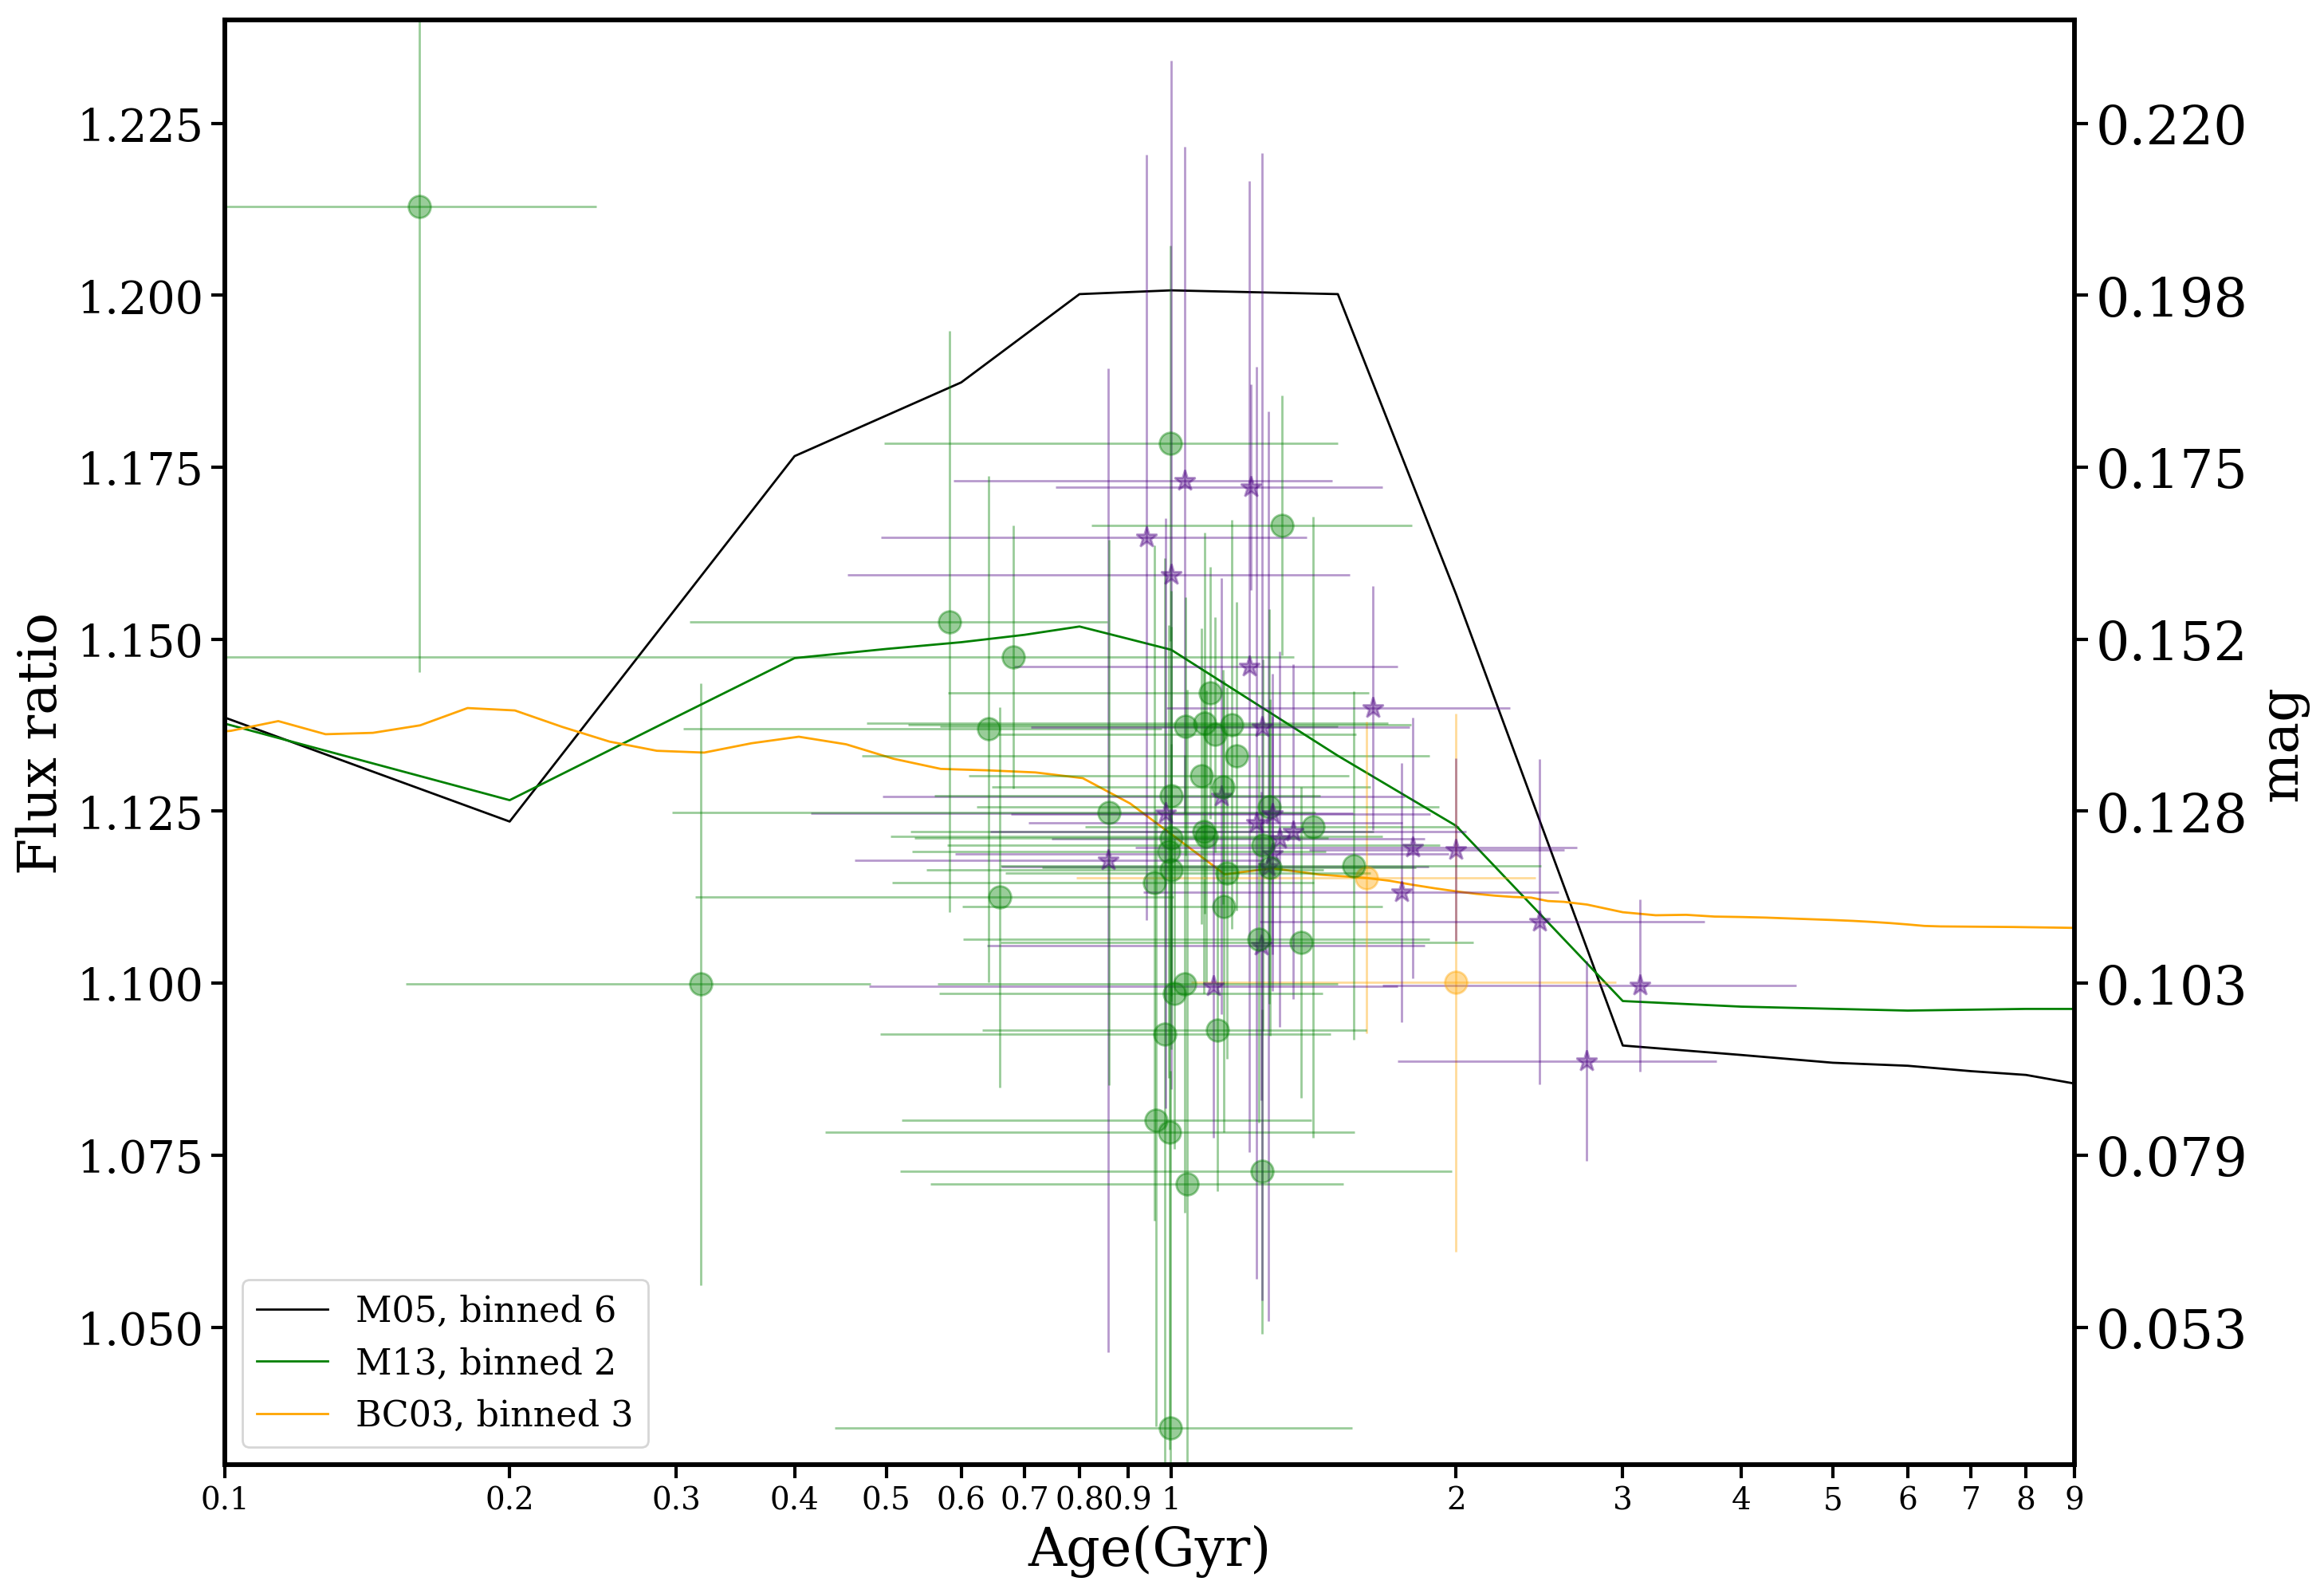

In [325]:
### CN_age plot based on new_model: scatter points
date='20200410'
fig=plt.figure(figsize=(16,12),dpi=200)
plt.rc('lines', linewidth=1, markersize=2)
plt.rc('font', size=24, family='serif', weight=300)
plt.rc('mathtext', fontset='stix')
plt.rc('axes', linewidth=2)
plt.rc('xtick.major', width=1.5, size=6)
plt.rc('ytick.major', width=1.5, size=6)
plt.tick_params(axis='both', which='major', labelsize=20)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
CN_69 = CN_list_new

colorset=['indigo','k','g','orange']
fmtset = ['*','o','o','o']

for i in range(len(CN_69)):
#     print(i)
    c = CN_69.model_new.values.astype(int)[i]
    ax1.errorbar(CN_69.iloc[i].age_opt,\
             CN_69.iloc[i].flux_ratio_AV_corr,\
             xerr=CN_69.iloc[i].age_opt_std,\
             yerr=CN_69.iloc[i].flux_ratio_err_AV_corr,\
             color=colorset[c],\
             markersize=10,\
             alpha=0.4,\
             zorder=10,\
             fmt=fmtset[c])

# unattenuated
ax1.plot(df_Ma.Age.unique(),Lick_index_list_M05_SSP_smoothed_6,color='k',\
         label='M05, binned 6')
ax1.plot(df_M13.Age.unique(),Lick_index_list_M13_SSP_smoothed_2,color='green',\
         label='M13, binned 2')
ax1.plot(BC03_age_list.astype(np.float)/1e9,Lick_index_list_BC03_SSP_smoothed_3,color='orange',\
         label='BC03, binned 3')



ax1Ys = ax1.get_yticks()
ax2Ys = []
for Y in ax1Ys:
    tick = "{0:.3f}".format(2.5*np.log10(Y))
    ax2Ys.append(tick)

ax2.set_yticks(ax1Ys)
ax2.set_ybound(ax1.get_ybound())
ax2.set_yticklabels(ax2Ys)

ax1.legend(prop={'size':14}, loc='lower left')

ax1.legend(prop={'size':16}, loc='lower left')
tick_labels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,\
             3,4,5,6,7,8,9]



fig.subplots_adjust(right=0.85)
ax1.set_xlim(0.1,9)
ax1.set_ylim([1.03, 1.24])


ax1.semilogx()
ax1.set_xticks(tick_labels)
ax1.set_xticklabels(tick_labels,fontsize=14)
ax1.set_xlabel('Age(Gyr)')
ax1.set_ylabel('Flux ratio')
ax2.set_ylabel('mag')


fn_fig = current_dir+outcome_dir+plot_dir+'flux_ratio_age_mag_binned_smoothed_4_cross-matches_smoothed_'+date+'new_model_new_err_no_removal.png'
fig.savefig(fn_fig)


In [326]:
M05 = CN_list_new[CN_list_new.model_new==1]
M13 = CN_list_new[CN_list_new.model_new==2]
BC03 = CN_list_new[CN_list_new.model_new==3]
TPAGB_heavy = pd.concat([M05,M13])
print(len(M05),len(M13),len(BC03),\
      len(TPAGB_heavy))

def bin_flux_ratio(group_data,bins=10):
    # the input group_data should be in the form of a dataframe
    data_cut,ret_bins = pd.qcut(group_data.age_opt.rank(method='first'),bins,retbins=True,duplicates='drop')
    print(ret_bins)
    print(pd.qcut(group_data.age_opt.rank(method='first'),bins).value_counts())
    grp = group_data.groupby(by=data_cut) 
    ret = grp.aggregate(np.mean)  
    ret_std = grp.aggregate(np.std)
    return ret, ret_std
# M05_ret, M05_std = bin_flux_ratio(M05,2)
M13_ret, M13_std = bin_flux_ratio(M13,4)
BC03_ret, BC03_std = bin_flux_ratio(BC03,2)
# tot_ret, tot_std = bin_flux_ratio(CN_selected,6)
TPAGB_heavy_ret, TPAGB_heavy_std = bin_flux_ratio(TPAGB_heavy,4)
print(M13_ret.age_opt)

0 42 2 42
[ 1.   11.25 21.5  31.75 42.  ]
(31.75, 42.0]     11
(0.999, 11.25]    11
(21.5, 31.75]     10
(11.25, 21.5]     10
Name: age_opt, dtype: int64
[1.  1.5 2. ]
(1.5, 2.0]      1
(0.999, 1.5]    1
Name: age_opt, dtype: int64
[ 1.   11.25 21.5  31.75 42.  ]
(31.75, 42.0]     11
(0.999, 11.25]    11
(21.5, 31.75]     10
(11.25, 21.5]     10
Name: age_opt, dtype: int64
age_opt
(0.999, 11.25]    0.709395
(11.25, 21.5]     1.010589
(21.5, 31.75]     1.107914
(31.75, 42.0]     1.296619
Name: age_opt, dtype: float64


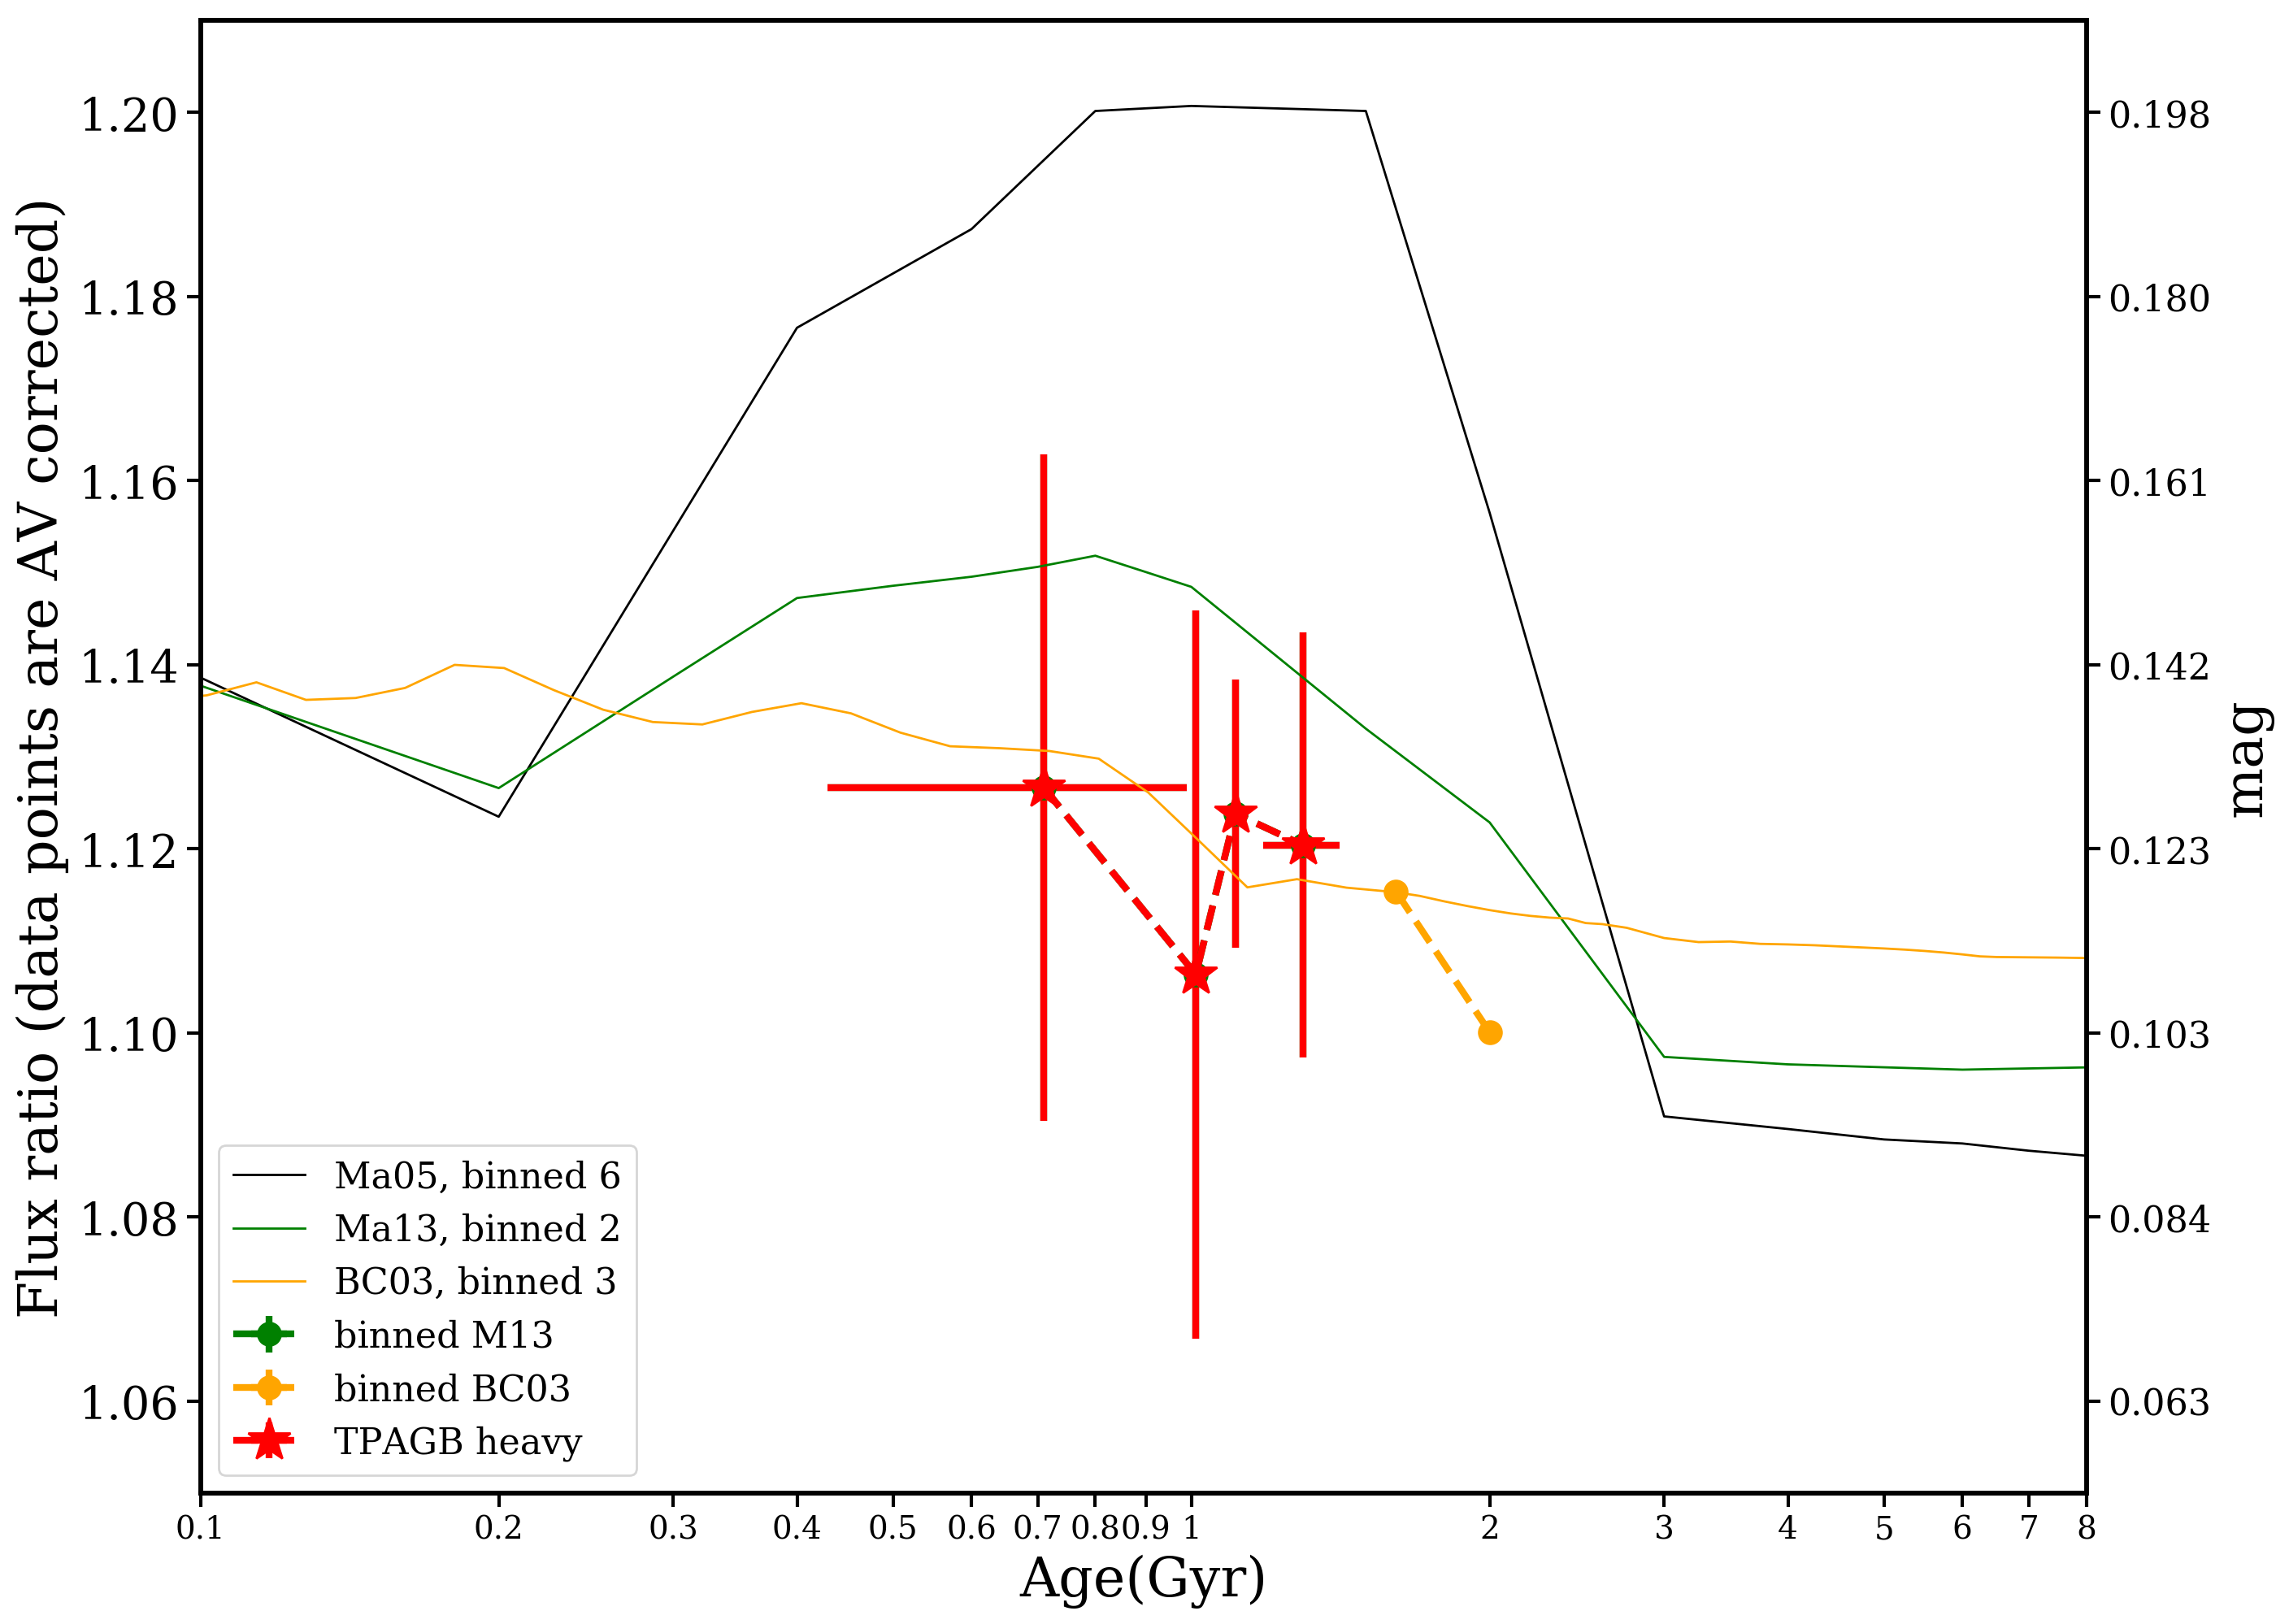

In [327]:
### based on model_new
fig=plt.figure(figsize=(16,12),dpi=200)
plt.rc('lines', linewidth=1, markersize=2)
plt.rc('font', size=24, family='serif', weight=300)
plt.rc('mathtext', fontset='stix')
plt.rc('axes', linewidth=2)
plt.rc('xtick.major', width=1.5, size=6)
plt.rc('ytick.major', width=1.5, size=6)
plt.tick_params(axis='both', which='major', labelsize=20)

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
# CN_69=CN_69

colorset=['indigo','k','g','orange']

# attenuated
ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05_smoothed_6, label='Ma05, binned 6', color='k')

ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13_smoothed_2[1:], label='Ma13, binned 2', color='green')

ax1.plot(BC03_age_list_num, Lick_index_list_BC03_smoothed_3, label='BC03, binned 3', color='orange')

# ax1.errorbar(M05_ret.age_opt.values, M05_ret.flux_ratio_AV_corr.values, 
#              xerr=M05_std.age_opt.values,\
#              yerr=M05_std.flux_ratio_AV_corr.values,\
#          color='k',label='binned M05',lw=3,fmt='--o',markersize=10);
ax1.errorbar(M13_ret.age_opt.values, M13_ret.flux_ratio_AV_corr.values, \
             xerr=M13_std.age_opt.values,\
             yerr=M13_std.flux_ratio_AV_corr.values,\
         color='green',label='binned M13',lw=3,fmt='--o',markersize=10);
ax1.errorbar(BC03_ret.age_opt.values, BC03_ret.flux_ratio_AV_corr.values,\
             xerr=BC03_std.age_opt.values,\
             yerr=BC03_std.flux_ratio_AV_corr.values, color='orange',\
         label='binned BC03',lw=3,fmt='--o',markersize=10);
# ax1.plot(tot_ret.age_opt.dropna(),tot_ret.flux_ratio_AV_corr.dropna(),\
#          label='tot',marker='o',color='indigo',lw=3,markersize=10);
ax1.errorbar(TPAGB_heavy_ret.age_opt.values, TPAGB_heavy_ret.flux_ratio_AV_corr.values,\
             xerr=TPAGB_heavy_std.age_opt.values,\
             yerr=TPAGB_heavy_std.flux_ratio_AV_corr.values,\
         label='TPAGB heavy',fmt='--*',color='red',lw=3,markersize=20);
ax1.set_ylim([1.05, 1.21])
ax1Ys = ax1.get_yticks()
ax2Ys = []
for Y in ax1Ys:
    tick = "{0:.3f}".format(2.5*np.log10(Y))
    ax2Ys.append(tick)

ax2.set_yticks(ax1Ys)
ax2.set_ybound(ax1.get_ybound())
ax2.set_yticklabels(ax2Ys)
ax2.yaxis.set_tick_params(labelsize=16)
ax1.legend(prop={'size':16}, loc='lower left')
tick_labels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,\
             3,4,5,6,7,8]

fig.subplots_adjust(right=0.85)
ax1.set_xlim(0.1,8)
ax1.semilogx()
ax1.set_xticks(tick_labels)
ax1.set_xticklabels(tick_labels,fontsize=14)
ax1.set_xlabel('Age(Gyr)')
ax1.set_ylabel('Flux ratio (data points are AV corrected)')
ax2.set_ylabel('mag')
# ax1.axvline(0.1)
# ax1.axvline(3)

fn_fig = current_dir+outcome_dir+plot_dir+\
         'flux_ratio_age_68_attenuated_datapoints_AV_corr_binned'+date+'model_new_new_error_no_removal.png'
fig.savefig(fn_fig)

In [15]:
from bokeh.plotting import Figure,figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, CrosshairTool, CustomJS
from bokeh.layouts import column, row, gridplot
from bokeh.models.widgets import Button, RadioButtonGroup, Select, Slider
from bokeh.models import BasicTicker, ColorBar, ColumnDataSource, LinearColorMapper, PrintfTickFormatter
from bokeh.io import output_notebook, show

output_file("CN-age.html")


In [16]:
colorset = ['indigo','k','green','orange']
print(CN_list_new.model_new.values.astype(int))
print([colorset[i] for i in CN_list_new.model_new.values.astype(int)])

[0 2 2 0 3 0 2 2 0 0 2 2 0 0 2 0 2 2 2 2 2 3 0 0 2 2 2 0 0 2 2 0 2 2 0 2 2
 2 2 0 2 2 2 2 0 2 0 2 2 2 2 0 0 2 0 0 2 2 2 0 0 2 2 2 2 0 2 2]
['indigo', 'green', 'green', 'indigo', 'orange', 'indigo', 'green', 'green', 'indigo', 'indigo', 'green', 'green', 'indigo', 'indigo', 'green', 'indigo', 'green', 'green', 'green', 'green', 'green', 'orange', 'indigo', 'indigo', 'green', 'green', 'green', 'indigo', 'indigo', 'green', 'green', 'indigo', 'green', 'green', 'indigo', 'green', 'green', 'green', 'green', 'indigo', 'green', 'green', 'green', 'green', 'indigo', 'green', 'indigo', 'green', 'green', 'green', 'green', 'indigo', 'indigo', 'green', 'indigo', 'indigo', 'green', 'green', 'green', 'indigo', 'indigo', 'green', 'green', 'green', 'green', 'indigo', 'green', 'green']


In [17]:
sfh_imgs=CN_list_new.fig_name.values
# sfh_imgs.replace('/Volumes/My Passport/TPAGB/outcome/plot/CN/20200410/','./database/CN/')
sfh_imgs

# np.char.replace(sfh_imgs,'/Volumes/My Passport/TPAGB/outcome/plot/CN/20200410/','./database/CN/')

array(['../database/CN/CN_20200410_aegis_1_26380.pdf',
       '../database/CN/CN_20200410_aegis_2_14044.pdf',
       '../database/CN/CN_20200410_aegis_3_19820.pdf',
       '../database/CN/CN_20200410_aegis_3_26829.pdf',
       '../database/CN/CN_20200410_aegis_11_37275.pdf',
       '../database/CN/CN_20200410_aegis_14_21300.pdf',
       '../database/CN/CN_20200410_aegis_15_10415.pdf',
       '../database/CN/CN_20200410_aegis_16_19787.pdf',
       '../database/CN/CN_20200410_aegis_19_30005.pdf',
       '../database/CN/CN_20200410_aegis_28_11221.pdf',
       '../database/CN/CN_20200410_aegis_28_16063.pdf',
       '../database/CN/CN_20200410_aegis_30_14044.pdf',
       '../database/CN/CN_20200410_cosmos_1_19842.pdf',
       '../database/CN/CN_20200410_cosmos_1_20236.pdf',
       '../database/CN/CN_20200410_cosmos_1_20423.pdf',
       '../database/CN/CN_20200410_cosmos_1_21548.pdf',
       '../database/CN/CN_20200410_cosmos_1_21739.pdf',
       '../database/CN/CN_20200410_cosmos_1_21966.pd

In [20]:
M05_age_CN = pd.read_csv("../database/CN_age_M05_binned_6.csv")
M13_age_CN = pd.read_csv("../database/CN_age_M13_binned_2.csv")
BC_age_CN = pd.read_csv("../database/CN_age_BC_binned_3.csv")

In [21]:

# envcat is a dataframe that contains ID, redshift, RA, DEC, and Density_Contrast
# sfh_imgs is a list that contains all the filenames for the images I want to hover over
sfh_imgs=CN_list_new.fig_name.values
# print(sfh_imgs)
color_list =[colorset[i] for i in CN_list_new.model_new.values.astype(int)]
source = ColumnDataSource(data=dict(
    x=CN_list_new.age_opt,
    y=CN_list_new.flux_ratio_AV_corr,
    desc=CN_list_new.ID,
    model = color_list,
#     goods_ids = envcat['ID'].astype(int),
    imgs= sfh_imgs,
#     env_vals = colors,
    env_od = CN_list_new.field,
    env_region = CN_list_new.region,
#     masses = gal_mass,
))

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

TOOLTIPS = """
    <div>
        <div>
            <img
                src="@imgs" height="300" alt="@imgs" width="400"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="0"
            ></img>
        </div>
        <div>
            <span style="font-size: 15px; color: #966;">Field: @env_od,region: @env_region, Galaxy Id: @desc, </span>
        </div>
        <div>
            <span style="font-size: 15px; color: #696;"></span>
        </div>
    </div>
"""

p = figure(plot_width=700, plot_height=700, tooltips=TOOLTIPS,
           x_axis_type="log",x_range=(0.1,5),y_range=(1.03, 1.24),
           title="CN-age plot", tools = TOOLS)
p.xaxis.axis_label = 'Age(Gyr)'
p.yaxis.axis_label = r'Flux Ratio'


# unattenuated
p.line(M05_age_CN.age, M05_age_CN.CN, line_color='black')
         
p.line(M13_age_CN.age, M13_age_CN.CN,line_color='green')
        
p.line(BC_age_CN.age, BC_age_CN.CN,color='orange')
    


p.circle('x', 'y',  source=source, color='model',
         fill_alpha=0.3, hover_alpha=1.0)

p.toolbar.autohide = True

output_notebook()
show(p)

Loading BokehJS ...